In [65]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score
import matplotlib.colors as colors
import matplotlib.pyplot as plt

data = pd.read_csv("Predict_Academic_Success_Modified.csv")

# Convert Target labels to numeric values
label_encoder = LabelEncoder()
data["Target"] = label_encoder.fit_transform(data["Target"])  # Dropout = 0, Enrolled = 1, Graduate = 2

# Separate features (X) and target (y)
X = data.iloc[:, :-1]  # All columns except Target
y = data["Target"]  # Target column

# encode categorical features
categorical_cols = ["Previous qualification", "Mother's qualification", "Father's qualification", "Nacionality",
                    "Mother's occupation", "Father's occupation", "Marital status", "Application mode",
                    "Course", "Daytime/evening attendance", "Displaced", "Educational special needs",
                    "Debtor", "Tuition fees up to date", "Gender", "Scholarship holder", "International"]

for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col])

# Standardize features for better SVM performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into 90% training & testing, 10% unseen
X_train_test, X_unseen, y_train_test, y_unseen = train_test_split(
    X_scaled, y, test_size=0.10, random_state=42, stratify=y)

# Split 90% into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X_train_test, y_train_test, test_size=0.20, random_state=42, stratify=y_train_test)

# Train SVM model with the training data
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Ten-fold cross validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=kf, scoring="accuracy") 

# Predict for the test data
y_pred = svm_model.predict(X_test)


Testing Data Evaluation Results



,Metric,Value
0,Cross-Validation Accuracy,0.768849
1,Accuracy,0.752823
2,Precision,0.746617
3,Recall,0.752823
4,ROC-AUC Score,0.864420


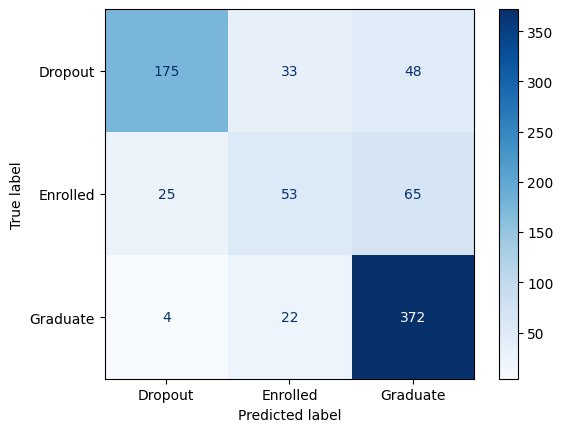

In [66]:
# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# ROC-AUC requires probability estimates and binary/multi-class consideration
roc_auc = roc_auc_score(y_test, svm_model.predict_proba(X_test), multi_class='ovr')  # One-vs-Rest for multi-class

# Return results
testing_metric = {
    "Metric" : [
        "Cross-Validation Accuracy",
        "Accuracy",
        "Precision",
        "Recall",
        "ROC-AUC Score"
    ],
    "Value": [
        np.mean(cv_scores),
        accuracy,
        precision,
        recall,
        roc_auc
    ]
}
testing_metric_df = pd.DataFrame(testing_metric)

# Display Confusion Matrix of testing data
class_names = ['Dropout', 'Enrolled', 'Graduate']
disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=class_names,
        cmap=plt.cm.Blues)

# Display the results for testing data
print("\nTesting Data Evaluation Results\n")
testing_metric_df


In [64]:
y_unseen_predict = svm_model.predict(X_unseen)
y_unseen_predict_labels = label_encoder.inverse_transform(y_unseen_predict)
unseen_svm = pd.DataFrame({"Actual": label_encoder.inverse_transform(y_unseen), "Predicted": y_unseen_predict_labels})
unseen_svm.to_csv("SVM Algorithm's Predictions for Unseen Data.csv", index=False)